In [1]:
# Import necessary libraries 
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader     # Import loader for dataset (data - spliter)
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt 

# Declare the device to execute the task (gpu - cuda, cpu - cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Download the MNIST dataset

In [2]:
trainingData = FashionMNIST(root='data',
                     train=True,
                     download=True)

testingData = FashionMNIST(root='data',
                    train=False,
                    download=True)

100.0%
100.0%
100.0%
100.0%


### FashionMNIST - No Normalization - Softmax Regression

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.0, ), (1.0, ))])

trainingData = FashionMNIST(root='data', train=True, download=False, transform=transform)
trainLoader = DataLoader(trainingData, batch_size=1024, shuffle=True, num_workers=10)

testingData = FashionMNIST(root='data', train=False, download=False, transform=transform)
testLoader = DataLoader(trainingData, batch_size=1024, shuffle=False, num_workers=10)

In [4]:
softmaxRegressionModel = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=10)
)

softmaxRegressionModel = softmaxRegressionModel.to(device)
print(softmaxRegressionModel)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(softmaxRegressionModel.parameters(), lr=1e-4)

In [11]:
def computeMean(loader):
    mean = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    return mean / len(loader.dataset)

In [14]:
def computeStandardDeviation(loader, mean):
    variance = 0.0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        variance += ((images - mean.unsqueeze(1))**2).sum([0, 2])
    standardDeviation = torch.sqrt(variance / (len(loader.dataset)*28*28))
    return standardDeviation

In [7]:
def evaluateModel(model, testLoader, criterion):
    model.eval()
    testLoss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():

        for images, labels in testLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            testLoss += loss.item()

            _, predicted = torch.max(outputs.data, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    testLoss = testLoss / len(testLoader)
    return accuracy, testLoss 

In [10]:
def trainModel(numberOfEpochs, trainLoader, testLoader, criterion, optimizer, model, device):
    trainLosses = []
    trainAccuracies = []
    testLosses = []
    testAccuracies = []

    for epoch in range(numberOfEpochs):
        
        trainLoss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainLoader, 0):

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            trainLoss += loss.item()

            _, predicted = torch.max(outputs.data, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loss.backward()
            optimizer.step()
        
        trainAccuracy = 100 * correct / total
        trainLoss = trainLoss / (i+1)
        testAccuracy, testLoss = evaluateModel(model, testLoader, criterion)
        print(f"Epoch {epoch+1}/{numberOfEpochs}, Accuracy: {trainAccuracy:.2f}, Loss: {trainLoss:.4f}, Accuracy: {testAccuracy:.2f}, Loss: {testLoss:.4f}")
    
        trainAccuracies.append(trainAccuracy)
        trainLosses.append(trainLoss)
        testAccuracies.append(testAccuracy)
        testLosses.append(testLoss)

    return trainAccuracies, trainLosses, testAccuracies, testLosses


In [9]:
trainAccuracies, trainLosses, testAccuracies, testLosses = trainModel(numberOfEpochs=50, trainLoader = trainLoader, 
                                                                    testLoader = testLoader, criterion=criterion, 
                                                                    optimizer=optimizer, model=softmaxRegressionModel, device=device)

Epoch 1/50, Accuracy: 14.93, Loss: 2.2916, Accuracy: 15.56, Loss: 2.2829
Epoch 2/50, Accuracy: 16.15, Loss: 2.2748, Accuracy: 16.71, Loss: 2.2664
Epoch 3/50, Accuracy: 17.26, Loss: 2.2588, Accuracy: 17.78, Loss: 2.2507
Epoch 4/50, Accuracy: 18.29, Loss: 2.2432, Accuracy: 18.80, Loss: 2.2356
Epoch 5/50, Accuracy: 19.23, Loss: 2.2285, Accuracy: 19.70, Loss: 2.2210
Epoch 6/50, Accuracy: 20.12, Loss: 2.2142, Accuracy: 20.62, Loss: 2.2070
Epoch 7/50, Accuracy: 21.08, Loss: 2.2003, Accuracy: 21.54, Loss: 2.1934
Epoch 8/50, Accuracy: 21.99, Loss: 2.1870, Accuracy: 22.45, Loss: 2.1802
Epoch 9/50, Accuracy: 23.00, Loss: 2.1740, Accuracy: 23.62, Loss: 2.1674
Epoch 10/50, Accuracy: 24.28, Loss: 2.1614, Accuracy: 24.91, Loss: 2.1550
Epoch 11/50, Accuracy: 25.54, Loss: 2.1491, Accuracy: 26.17, Loss: 2.1429
Epoch 12/50, Accuracy: 26.86, Loss: 2.1372, Accuracy: 27.56, Loss: 2.1312
Epoch 13/50, Accuracy: 28.18, Loss: 2.1257, Accuracy: 28.83, Loss: 2.1197
Epoch 14/50, Accuracy: 29.47, Loss: 2.1144, Acc

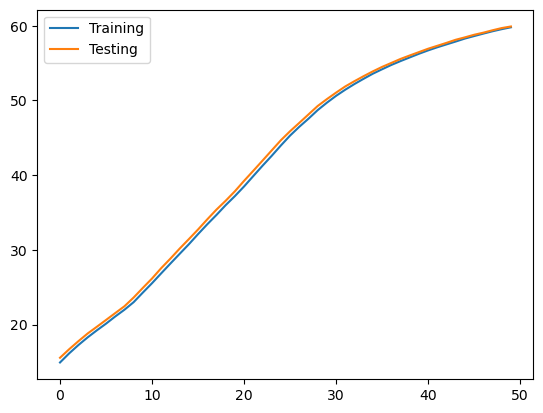

In [10]:
plt.plot(trainAccuracies, label='Training')
plt.plot(testAccuracies, label='Testing')
plt.legend()
plt.show()

### FashionMNIST - Norminalisation - Softmax Regression

In [15]:
transform = transforms.Compose([transforms.ToTensor()])

trainingData = FashionMNIST(root='data', download=False, train=True, transform=transform)
trainLoader = DataLoader(trainingData, batch_size=1024, num_workers=10, shuffle=True)

meanTrainingData = computeMean(trainLoader)
standardDeviation = computeStandardDeviation(trainLoader, meanTrainingData)

print(meanTrainingData, standardDeviation)



tensor([0.2860]) tensor([0.3530])


In [16]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((meanTrainingData,), (standardDeviation,))])

trainingData = FashionMNIST(root='data', download=False, train=True, transform=transform)
trainLoader = DataLoader(trainingData, batch_size=1024, num_workers=10, shuffle=True)

testingData = FashionMNIST(root='data', download=False, train=False, transform=transform)
testLoader = DataLoader(trainingData, batch_size=1024, num_workers=10, shuffle=False)

In [17]:
softmaxRegressionModel = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=10)
)
softmaxRegressionModel = softmaxRegressionModel.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(softmaxRegressionModel.parameters(), lr=0.01)

In [19]:
trainAccuracies, trainLosses, testAccuracies, testLosses = trainModel(numberOfEpochs=50, trainLoader = trainLoader, 
                                                                    testLoader = testLoader, criterion=criterion, 
                                                                    optimizer=optimizer, model=softmaxRegressionModel, device=device)

Epoch 1/50, Accuracy: 66.35, Loss: 1.1120, Accuracy: 74.22, Loss: 0.8123
Epoch 2/50, Accuracy: 75.84, Loss: 0.7459, Accuracy: 77.06, Loss: 0.6947
Epoch 3/50, Accuracy: 77.86, Loss: 0.6664, Accuracy: 78.56, Loss: 0.6404
Epoch 4/50, Accuracy: 79.01, Loss: 0.6236, Accuracy: 79.63, Loss: 0.6071
Epoch 5/50, Accuracy: 79.93, Loss: 0.5957, Accuracy: 80.25, Loss: 0.5840
Epoch 6/50, Accuracy: 80.51, Loss: 0.5757, Accuracy: 80.81, Loss: 0.5664
Epoch 7/50, Accuracy: 80.97, Loss: 0.5598, Accuracy: 81.18, Loss: 0.5532
Epoch 8/50, Accuracy: 81.44, Loss: 0.5476, Accuracy: 81.58, Loss: 0.5415
Epoch 9/50, Accuracy: 81.73, Loss: 0.5371, Accuracy: 81.94, Loss: 0.5324
Epoch 10/50, Accuracy: 81.96, Loss: 0.5288, Accuracy: 82.09, Loss: 0.5243
Epoch 11/50, Accuracy: 82.19, Loss: 0.5216, Accuracy: 82.36, Loss: 0.5173
Epoch 12/50, Accuracy: 82.51, Loss: 0.5149, Accuracy: 82.54, Loss: 0.5112
Epoch 13/50, Accuracy: 82.66, Loss: 0.5096, Accuracy: 82.70, Loss: 0.5060
Epoch 14/50, Accuracy: 82.84, Loss: 0.5047, Acc

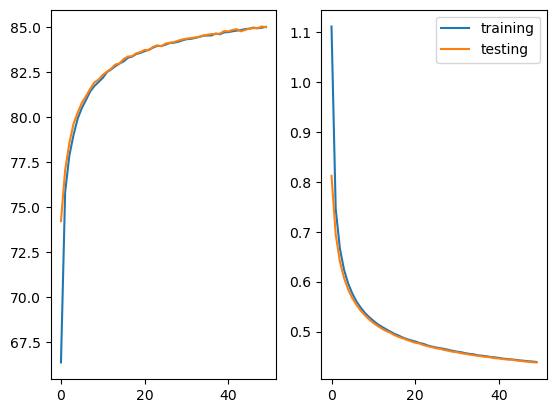

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(trainAccuracies, label="training")
axes[0].plot(testAccuracies, label="testing")

axes[1].plot(trainLosses, label="training")
axes[1].plot(testLosses, label="testing")

plt.legend()
plt.show()

### Fashion MNIST - Normalization - MLP

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.0,), (1.0,))])

trainingData = FashionMNIST(root='data', download=False, train=True, transform=transform)
trainLoader = DataLoader(trainingData, batch_size=1024, num_workers=10, shuffle=True)

testingData = FashionMNIST(root='data', download=False, train=False, transform=transform)
testLoader = DataLoader(testingData, batch_size=1024, num_workers=10, shuffle=False)

In [12]:
MLP = nn.Sequential(
    nn.Flatten(), nn.Linear(784, 512),
    nn.ReLU(), nn.Linear(512, 256),
    nn.ReLU(), nn.Linear(256, 10)
)
MLP = MLP.to(device)

In [4]:
print(MLP)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=True)
)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP.parameters(), lr=0.01)

In [14]:
trainAccuracies, trainLosses, testAccuracies, testLosses = trainModel(numberOfEpochs=20, trainLoader=trainLoader, testLoader=testLoader,
                                                                      criterion=criterion, optimizer=optimizer, model=MLP, device=device)

Epoch 1/20, Accuracy: 20.82, Loss: 2.2661, Accuracy: 38.30, Loss: 2.2278
Epoch 2/20, Accuracy: 43.50, Loss: 2.1825, Accuracy: 48.59, Loss: 2.1288
Epoch 3/20, Accuracy: 52.44, Loss: 2.0578, Accuracy: 55.08, Loss: 1.9753
Epoch 4/20, Accuracy: 57.34, Loss: 1.8723, Accuracy: 58.08, Loss: 1.7620
Epoch 5/20, Accuracy: 59.28, Loss: 1.6475, Accuracy: 61.24, Loss: 1.5400
Epoch 6/20, Accuracy: 61.53, Loss: 1.4433, Accuracy: 62.27, Loss: 1.3608
Epoch 7/20, Accuracy: 63.08, Loss: 1.2864, Accuracy: 62.32, Loss: 1.2282
Epoch 8/20, Accuracy: 63.87, Loss: 1.1700, Accuracy: 63.40, Loss: 1.1299
Epoch 9/20, Accuracy: 64.88, Loss: 1.0829, Accuracy: 64.39, Loss: 1.0553
Epoch 10/20, Accuracy: 65.81, Loss: 1.0158, Accuracy: 64.53, Loss: 0.9973
Epoch 11/20, Accuracy: 66.73, Loss: 0.9622, Accuracy: 65.39, Loss: 0.9504
Epoch 12/20, Accuracy: 67.43, Loss: 0.9189, Accuracy: 66.51, Loss: 0.9121
Epoch 13/20, Accuracy: 68.11, Loss: 0.8829, Accuracy: 67.10, Loss: 0.8804
Epoch 14/20, Accuracy: 68.81, Loss: 0.8528, Acc

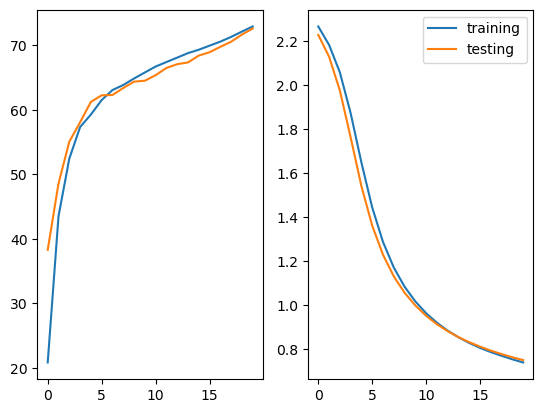

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(trainAccuracies, label="training")
axes[0].plot(testAccuracies, label="testing")

axes[1].plot(trainLosses, label="training")
axes[1].plot(testLosses, label="testing")

plt.legend()
plt.show()